In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [10]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [11]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [12]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
210101,R.MDKVHSEAER.L,QQKVLQQRMDKVHSE,KVHSEAERLEARFQD,VLQQRMDKVHSEAER,-,sp|Q96M63|CC114_HUMAN,MDKVHSEAER,0


In [13]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [14]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(215352, 39) (215352, 30) (215352, 15) (215352, 15) (215352, 15) (215352, 15) (215352,)
(53838, 39) (53838, 30) (53838, 15) (53838, 15) (53838, 15) (53838, 15) (53838,)
(67298, 39) (67298, 30) (67298, 15) (67298, 15) (67298, 15) (67298, 15) (67298,)


# Train

In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [16]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# Transformer

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [58]:
vocab_size = 21  # 20 Amino acid + zero padding
maxlen_pep = 30
maxlen_ts = 15

pep_embed_dim = 64  # Embedding size for each token
pep_num_heads = 4  # Number of attention heads
pep_ff_dim = 64  # Hidden layer size in feed forward network inside transformer

ts_embed_dim = 32  # Embedding size for each token
ts_num_heads = 4  # Number of attention heads
ts_ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [65]:
embedding_layer_pep = TokenAndPositionEmbedding(maxlen_pep, vocab_size, pep_embed_dim)
transformer_block_pep = TransformerBlock(pep_embed_dim, pep_num_heads, pep_ff_dim)
embedding_layer_ts = TokenAndPositionEmbedding(maxlen_ts, vocab_size, ts_embed_dim)
transformer_block_ts = TransformerBlock(ts_embed_dim, ts_num_heads, ts_ff_dim)

pep_input = layers.Input(shape=(maxlen_pep,))
pep_embed = embedding_layer_pep(pep_input)
pep_enc = transformer_block_pep(pep_embed)

input2 = tf.keras.layers.Input(shape=((39,)))  # peptide info

n_input = layers.Input(shape=(maxlen_ts,))
n_embed = embedding_layer_ts(n_input)
n_enc = transformer_block_ts(n_embed)

c_input = layers.Input(shape=(maxlen_ts,))
c_embed = embedding_layer_ts(c_input)
c_enc = transformer_block_ts(c_embed)

m1_input = layers.Input(shape=(maxlen_ts,))
m1_embed = embedding_layer_ts(m1_input)
m1_enc = transformer_block_ts(m1_embed)

m2_input = layers.Input(shape=(maxlen_ts,))
m2_embed = embedding_layer_ts(m2_input)
m2_enc = transformer_block_ts(m2_embed)

cnn1 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(pep_enc)
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(cnn1)
net_lstm_ = tf.keras.layers.Dense(32, activation='relu')(lstm1)
net_lstm1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_lstm_)
net_lstm2_ = tf.keras.layers.Dense(16, activation='relu')(net_lstm1)
net_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_lstm2_)

net_dense1_ = tf.keras.layers.Dense(16, activation='relu')(input2)
net_dense1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_dense1_)

cnn3 = tf.keras.layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='same')(n_enc)
digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn3)
net_n_ = tf.keras.layers.Dense(16, activation='relu')(digest_n)
net_n1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_n_)
net_n2_ = tf.keras.layers.Dense(8, activation='relu')(net_n1)
net_n = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_n2_)

cnn4 = tf.keras.layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='same')(c_enc)
digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn4)
net_c_ = tf.keras.layers.Dense(16, activation='relu')(digest_c)
net_c1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_c_)
net_c2_ = tf.keras.layers.Dense(8, activation='relu')(net_c1)
net_c = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_c2_)

cnn5 = tf.keras.layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='same')(m1_enc)
digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn5)
net_m1_ = tf.keras.layers.Dense(16, activation='relu')(digest_m1)
net_m11 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m1_)
net_m12_ = tf.keras.layers.Dense(8, activation='relu')(net_m11)
net_m1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m12_)

cnn6 = tf.keras.layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='same')(m2_enc)
digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn6)
net_m2_ = tf.keras.layers.Dense(16, activation='relu')(digest_m2)
net_m21 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m2_)
net_m22_ = tf.keras.layers.Dense(8, activation='relu')(net_m21)
net_m2 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m22_)

merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense1,
                                    net_n,
                                    net_c,
                                    net_m1,
                                    net_m2
                                    ])

net1 = tf.keras.layers.Dense(64, activation='relu')(merge)
net1_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net1)
# net3 = tf.keras.layers.Dense(64, activation='relu')(net1_drop)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net1_drop)

model = tf.keras.Model(inputs=[pep_input, input2,
                              n_input, c_input,
                              m1_input, m2_input],
                       outputs=[output])

model.summary()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_87 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_88 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           [(None, 15)]         0                                            
___________________________________________________________________________________________

In [66]:
history = model.fit(
                    [pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=64,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
)

Epoch 1/300
3365/3365 [==============================] - 117s 31ms/step - loss: 9.0687 - accuracy: 0.6033 - val_loss: 0.4862 - val_accuracy: 0.7887
Epoch 2/300
3365/3365 [==============================] - 99s 29ms/step - loss: 0.6183 - accuracy: 0.7581 - val_loss: 0.4253 - val_accuracy: 0.8108
Epoch 3/300
3365/3365 [==============================] - 98s 29ms/step - loss: 0.4434 - accuracy: 0.8020 - val_loss: 0.4033 - val_accuracy: 0.8184
Epoch 4/300
3365/3365 [==============================] - 99s 29ms/step - loss: 0.4167 - accuracy: 0.8156 - val_loss: 0.3977 - val_accuracy: 0.8224
Epoch 5/300
3365/3365 [==============================] - 101s 30ms/step - loss: 0.4054 - accuracy: 0.8201 - val_loss: 0.3958 - val_accuracy: 0.8219
Epoch 6/300
3365/3365 [==============================] - 98s 29ms/step - loss: 0.3980 - accuracy: 0.8238 - val_loss: 0.3858 - val_accuracy: 0.8268
Epoch 7/300
3365/3365 [==============================] - 97s 29ms/step - loss: 0.3869 - accuracy: 0.8298 - val_loss:

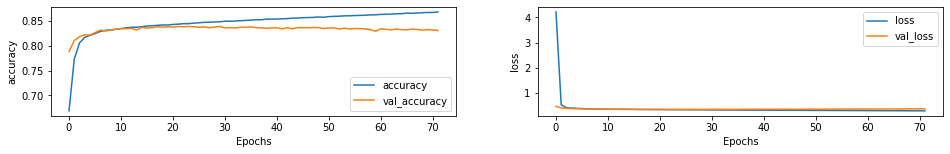

In [67]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

2104/2104 [==============================] - 20s 10ms/step - loss: 0.3820 - accuracy: 0.8318
Test Loss: 0.38199833035469055
Test Accuracy: 0.8317780494689941
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     33706
           1       0.83      0.84      0.83     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298

rf auc : 0.9101830512896304


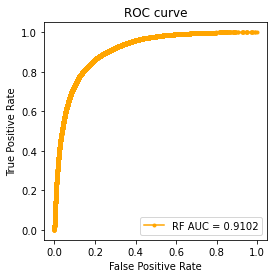

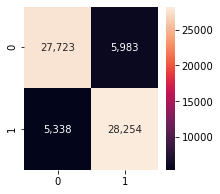

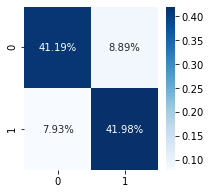

In [68]:
test_loss, test_acc = model.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# not good enough